# eXplainable Artificial Intelligence 

### By Apostolos Kakampakos 03400133, Dimitris Karpontinis 03400135

This presentation about XAI and its various methods is for the course Artificial Intelligence and Data Analysis of the Data Science and Machine Learning Master's program in National Technical University of Athens.

## Artificial Intelligence 

But what is AI? As a field artificial intelligence probably has its roots in the seminal paper of Alan Turing about thinking machines \cite{Turing}, with it growing ever since. The most popular subfield is none other than machine learning! As a discipline, machine learning is focused in various learning tasks, like Vision and Language Processing. Many techniques have come out over the years, some rule based like decision trees \cite{Quinlan} and some data driven like neural networks \cite{rosenblatt}. A different direction in artificial intelligence is the field of symbolic AI \cite{symbols}. In this principle various methods like description logic \cite{descriptionlogic} are used to represent knowledge about the world, in a similar manner we humans do also. As an added bonus, these methods are human readable, therefore can be understood by humans. This comes at a great price, namely someone must write this knowledge in a highly ordered and detailed form. On the other hand Neural Networks don't really need excessive human effort to accurately represent data, but they need great amounts of data to be able to "learn". In recent years we have seen the rise of Deep Learning \cite{Deng}, which requires immense amounts of data (labeled or not). Impressively it reaches in many tasks, human level accuracies. Despite their impressive results in vision and language tasks, they are considered black boxes! This brings up an important issue. How could we know a black box model like that decides in a sensible manner?! This immediately raises safety and trust concerns for many possible implementation of deep learning, like automated driving, detecting anomalies in medical data, producing medicine and so much more!

<center><figure><img src="ai.jpeg" style="width: 500px;"/>
          <figcaption>Source: https://medium.com/nerd-for-tech/ai-vs-machine-learning-vs-deep-learning-60b3d0611fe9</figcaption></figure></center>

## XAI

XAI attempts to tackle the aforementioned trust and security issues of our neural networks with various methods \cite{xai}. As it is discussed in that paper, xai is not only important for trust, but also for detecting adversarial perturbations that could change the prediction. All in all, understanding how a "bad" model is misbehaving can save us hours of training in a grid-search like fashion! Furthermore, if the model interpretations give meaningful explanations, we can claim our model "really" reasons instead of just being a function, which happens to be correctly predicting what we give it.

### Defining Terms

**Explainer**: A model or algorithm that receives a trained model and an input and provides an explanation for the output of said trained model to the given input.  

**Understandability**: It denotes the ability of an explainer method to provide human understandable explanations, without the need to express how the model to be explained treats the data.

**Comprehensibility**: For a ML model, is when it represents its learned knowledge in a human understandable fashion. (For example a Knowledge Base)

**Transparency**: We need to have our explanations being produced by an explainable in it self method. If not, why would we trust the explanation? 

**Audience**: The ones who receive the explanation. 

### XAI Goals

The various goals xai algorithms need to tackle are: 

* Trustworthiness
* Causality
* Transferability
* Informativeness
* Confidence
* Fairness
* Accessibility
* Interactivity
* Privacy awareness

### Explanation Types

* Text explanations
* Visual explanations
* Local explanations
* Explanations by example
* Explanations by simplification
* Feature relevance explanation m

...needs more...

# Main part

Having delved into the various intricacies of XAI, we will now present different explanation methods on a pre-trained model, and a dataset.

## Dataset

For our dataset we will use images from the **coco** dataset \cite{coco}. This dataset is full of real-world images containing various classes of objects. This dataset is used for segmenting individual object instances. The Microsoft Common Objects in COntext (MS
COCO) dataset contains 91 common object categories.  In total the dataset has 2,500,000 labeled
instances in 328,000 images.

In [6]:
import json
from coco_dataset import COCO


# Load Json File with annotations
with open("./annotations/instances_train2014.json", "rb") as f:
    data = json.load(f)

#loads coco dataset containing all urls
coco = COCO(data)

/Users/apostolos/miniforge3/envs/python38-demo-v2/lib/python3.8/site-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 8.1.2. Several security issues (CVE-2021-27921, CVE-2021-25290, CVE-2021-25291, CVE-2021-25293, and more) have been fixed in pillow 8.1.2 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper
 18%|█▊        | 109375/604907 [00:00<00:00, 1093693.68it/s]

Loading Coco Metadata


100%|██████████| 604907/604907 [00:00<00:00, 612252.77it/s] 


Having loaded the entire coco 2014 dataset (at least its urls and contained objects), let us see a random image from our dataset!

{'url': 'http://farm6.staticflickr.com/5336/9646832678_3027b999de_z.jpg', 'label_ids': [3, 3, 3, 3, 7, 1, 33, 3, 3, 3, 6, 1, 3], 'label_texts': ['car', 'car', 'car', 'car', 'train', 'person', 'suitcase', 'car', 'car', 'car', 'bus', 'person', 'car']}


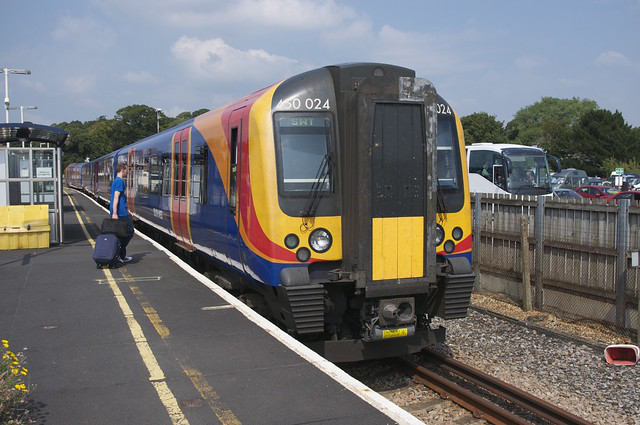

In [13]:
from predictor import read_image_from_url

img = coco.random_image()
url = img['url']

print(img)
read_image_from_url(url)

Every image contains its corresponding url (some urls unfortunately are down, more on that later), label_ids and label_texts which contain the names of the object said image contains! Let us now present the classifier we will use for all xai methods. 

For a classifier, we will use one of the pre-trained conv nets trained on the Places Dataset \cite{places}. Those models, which were used in the paper can be downloaded from the github repo: https://github.com/CSAILVision/places365

We selected to use Resnet18 \cite{resnet18} for our predictor. 

In [14]:
from predictor import Classifier 

resnet = Classifier("resnet18")

print("Predictions")
resnet.classify(url)

Predictions


[['train_station/platform', 0.8837059736251831],
 ['subway_station/platform', 0.07349731773138046],
 ['railroad_track', 0.03751059249043465],
 ['bus_station/indoor', 0.005036376416683197],
 ['industrial_area', 3.198465128662065e-05],
 ['ticket_booth', 2.3236087145050988e-05],
 ['amusement_park', 2.0823410523007624e-05],
 ['arch', 2.0459812731132843e-05],
 ['highway', 1.868800063675735e-05],
 ['bridge', 1.782670551619958e-05]]

## Prune and Join

As we have too many pictures, we should reduce the dataset size. We will perform this by picking 2 objects, that are not really related and are not in many pictures. Hopefully it will give us variety of objects and relations. We will pick ... surfboard and ... pizza ! Let us present the entire process.

In [16]:
#coco dataset...
coco = COCO(data)
coco2 = COCO(data)

print (f"COCO keys: {coco.coco[list(coco.coco.keys())[0]].keys()}")

#pruning dataset!!!
#pruning only keeps images that contain the object we want, for example pizza!

print (f"Size of dataset 1 before Pruning: {len(coco.coco)}")
coco.prune_dataset(["surfboard"])
print (f"Size of dataset 1 after Pruning: {len(coco.coco)}")

print (f"Size of dataset 2 before Pruning: {len(coco2.coco)}")
coco2.prune_dataset(["pizza"])
print (f"Size of dataset 2 after Pruning: {len(coco2.coco)}")

#join datasets to one!
coco.join(coco2)
print (f"Size of total dataset after Joining: {len(coco.coco)}")

 16%|█▋        | 99356/604907 [00:00<00:00, 993527.78it/s]

Loading Coco Metadata


 25%|██▍       | 150819/604907 [00:00<00:00, 1508144.69it/s]

Loading Coco Metadata


100%|██████████| 604907/604907 [00:00<00:00, 1431421.11it/s]


COCO keys: dict_keys(['url', 'label_ids', 'label_texts'])
Size of dataset 1 before Pruning: 82081
Size of dataset 1 after Pruning: 2343
Size of dataset 2 before Pruning: 82081
Size of dataset 2 after Pruning: 2202
Size of total dataset after Joining: 4543


Let us again see a random image! It has to either contain surfboard or pizza!!!

{'url': 'http://farm6.staticflickr.com/5068/5650097906_b7cf99b3c3_z.jpg', 'label_ids': [1, 42, 9], 'label_texts': ['person', 'surfboard', 'boat']}


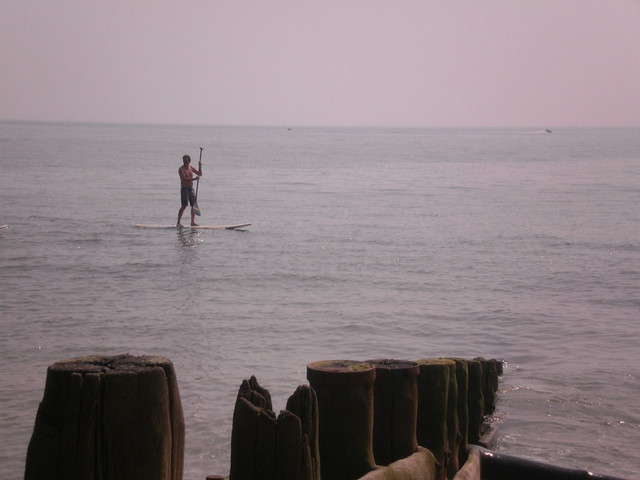

In [21]:
img = coco.random_image()
url = img['url']

print(img)
read_image_from_url(url)

As we can expect, since our image pool is now comprised of very specific object, the possible places our classifier predicts, will be considerably fewer!

In [22]:
print("Predictions")
resnet.classify(url)

Predictions


[['beach', 0.3747864365577698],
 ['ocean', 0.21645203232765198],
 ['coast', 0.14220526814460754],
 ['islet', 0.05959514155983925],
 ['lagoon', 0.03722235560417175],
 ['wave', 0.022335564717650414],
 ['harbor', 0.020554667338728905],
 ['ice_floe', 0.017206847667694092],
 ['ice_shelf', 0.014123567380011082],
 ['cliff', 0.013940690085291862]]

## Simple Knowledge

To represent an ontology we will use the python library owlready2 \cite{owlready2}. First let us see an ontology of a single image!

['person', 'person', 'surfboard', 'surfboard']


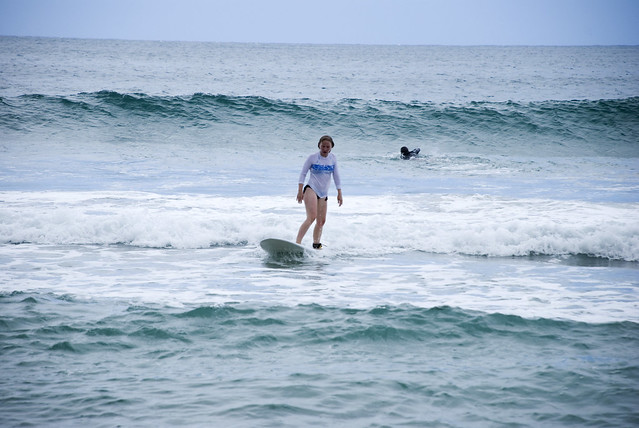

In [23]:
#We will pick an image from our dataset...

id = 327758
img = coco.coco[id]
#contained objects!
label_texts = img['label_texts']
url = img['url']

#visualize!

print(label_texts)
read_image_from_url(url)

# References

[<a id="cit-Turing" href="#call-Turing">1</a>] TURING A. M., ``_I.—COMPUTING MACHINERY AND INTELLIGENCE_'', Mind, vol. LIX, number 236, pp. 433-460, 10 1950.  [online](https://doi.org/10.1093/mind/LIX.236.433)

[<a id="cit-Quinlan" href="#call-Quinlan">2</a>] Quinlan J. R., ``_Induction of Decision Trees_'', Machine Learning, vol. 1, number , pp. 81--106,  1986.

[<a id="cit-rosenblatt" href="#call-rosenblatt">3</a>] Rosenblatt F., ``_The perceptron: A probabilistic model for information storage and organization in the brain._'', Psychological Review, vol. 65, number 6, pp. 386--408,  1958.  [online](http://dx.doi.org/10.1037/h0042519)

[<a id="cit-symbols" href="#call-symbols">4</a>] , ``_Computer science as empirical inquiry: symbols and search_'', , vol. 19, number 3, pp. 113-126,  1976.  [online](http://doi.acm.org/10.1145/1283920.1283930)

[<a id="cit-descriptionlogic" href="#call-descriptionlogic">5</a>] Franz Baader, Diego Calvanese, Deborah Mcguinness <em>et al.</em>, ``_The Description Logic Handbook: Theory, Implementation, and Applications_'', 01 2007.

[<a id="cit-Deng" href="#call-Deng">6</a>] Deng Li and Yu Dong, ``_Deep Learning: Methods and Applications_'', Found. Trends Signal Process., vol. 7, number , pp. 197-387,  2014.

[<a id="cit-xai" href="#call-xai">7</a>] (Barredo Alejandro, Díaz-Rodríguez Natalia, (Del Javier <em>et al.</em>, ``_Explainable Artificial Intelligence (XAI): Concepts, taxonomies, opportunities and challenges toward responsible AI_'', Information Fusion, vol. 58, number , pp. 82-115,  2020.  [online](https://www.sciencedirect.com/science/article/pii/S1566253519308103)

[<a id="cit-coco" href="#call-coco">8</a>] Tsung-Yi Lin, Michael Maire, Serge Belongie <em>et al.</em>, ``_Microsoft COCO: Common Objects in Context_'',  2014.  [online](http://arxiv.org/abs/1405.0312)

[<a id="cit-places" href="#call-places">9</a>] Zhou Bolei, Lapedriza {\`A}gata, Khosla Aditya <em>et al.</em>, ``_Places: A 10 Million Image Database for Scene Recognition_'', IEEE Transactions on Pattern Analysis and Machine Intelligence, vol. 40, number , pp. 1452-1464,  2018.

[<a id="cit-resnet18" href="#call-resnet18">10</a>] K. He, X. Zhang, S. Ren <em>et al.</em>, ``_Deep Residual Learning for Image Recognition_'', Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition (CVPR), June 2016.

[<a id="cit-owlready2" href="#call-owlready2">11</a>] Lamy Jean-Baptiste, ``_Owlready: Ontology-oriented programming in Python with automatic classification and high level constructs for biomedical ontologies_'', Artificial Intelligence in Medicine, vol. 80, number , pp. , 08 2017.

